In [33]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_predict
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.decomposition import PCA

In [34]:
score = pd.read_csv('../LBLS467-data/score.csv')
srl_motivation = pd.read_csv('../LBLS467-data/srl_motivation.csv')
sill = pd.read_csv('../LBLS467-data/sill.csv')
srl_strategy = pd.read_csv('../LBLS467-data/srl_strategy.csv')
br = pd.read_csv('../LBLS467-data/br.csv')
viscode = pd.read_csv('../LBLS467-data/viscode.csv')

In [35]:
from functools import reduce

dfs = [score, srl_motivation, sill, srl_strategy, br]

def merge_keep_left(left, right):
    right = right[[col for col in right.columns if col not in left.columns or col == "userid"]]
    return pd.merge(left, right, on="userid", how="inner")

merged = reduce(merge_keep_left, dfs)


In [7]:
X = merged.drop(["userid","class","score",'Unnamed: 0'], axis=1)  
y = merged["score"]

In [43]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_predict, KFold
from sklearn.metrics import mean_squared_error

def single_nudging_iteration(X, y, n_rounds=5, n_splits=5, plot_each_round=False, w=0.5, target_val=60):
    """
    Run iterative nudging simulation based on Moral Licensing.
    Formula: y_{t+1} = y_t - w * [y_hat - target]_+
    
    Parameters:
    - w (float): Weight of the nudging effect (how much they slack off).
    - target_val (float): The goal threshold (y_target).
    """
    current_y = y.copy()
    results = []
    pred_history = []
    nudged_history = []
    
    # record initial y 
    nudged_history.append(current_y.copy())

    for t in range(n_rounds):
        # 1. prediction model
        rf = RandomForestRegressor(n_estimators=200, random_state=42)
        kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
        all_preds = cross_val_predict(rf, X, current_y, cv=kf)
        pred_history.append(all_preds.copy())
        
        # calculate RMSE
        mse = mean_squared_error(current_y, all_preds)
        mean_rmse = np.sqrt(mse)

        # 2. Moral Licensing
        # Formula: y_{t+1} = y_t - w * max(0, y_hat - target)
        # [y_hat - target]_+ : calculate the part exceed the target (Excess)

        gap = np.maximum(0, all_preds - target_val)
        
        # Slacking off amount
        decay = w * gap
        
        # nudged y 
        new_y_values = current_y - decay
        new_y_values = np.clip(new_y_values, 1, 100)
        
        # update current_y
        current_y = pd.Series(new_y_values, index=y.index)
        nudged_history.append(current_y.copy())

        # 3. record the model performance, prediction, and nudged y
        results.append({
            "round": t+1,
            "cv_rmse": mean_rmse,
            "mean_dist_pred": np.mean(np.abs(current_y - all_preds)), # Nudged y vs. Prediction distance
            "mean_current_y": current_y.mean(),
            "mean_all_preds": all_preds.mean(),
            "w": w,
            "target": target_val
        })

        print(f"[Round {t+1}] CV RMSE={mean_rmse:.4f}, "
              f"Mean y={current_y.mean():.3f}, "
              f"Mean Pred={all_preds.mean():.3f}")
        
        # 4. visualization
        if plot_each_round:
            # we sort the prediction and given a new index for better visualization (Index = ranked by prediction)
            sort_idx = np.argsort(all_preds)
            plt.figure(figsize=(10, 6))
            
            # y_t
            plt.scatter(range(len(y)), y.iloc[sort_idx], color="lightgrey", alpha=0.5, label="Original Truth (y_0)")
            
            # y_hat_t
            plt.plot(range(len(y)), all_preds[sort_idx], color="blue", linewidth=1, label=f"Prediction (y_hat_{t})")
            
            # y_t+1
            plt.scatter(range(len(y)), current_y.iloc[sort_idx], color="red", s=10, alpha=0.6, label=f"Nudged Performance (y_{t+1})")
            
            # target line (threshold)
            plt.axhline(y=target_val, color='green', linestyle='--', label=f"Target ({target_val})")
            
            plt.xlabel("Sample Index (Sorted by Prediction)")
            plt.ylabel("Performance Score")
            plt.title(f"Moral Licensing Iteration {t+1}: High predictions lead to slacking off")
            plt.legend()
            plt.grid(True, alpha=0.3)
            plt.show()
        
    # we save the final model which affected by all nudging iterations
    final_model = RandomForestRegressor(n_estimators=200, random_state=42)
    final_model.fit(X, current_y)

    return results, y, final_model, pred_history, nudged_history

In [44]:
results, original_y, final_model, pred_history, nudged_history = single_nudging_iteration(
    X, 
    y,
    n_rounds=20,
    plot_each_round=False,
    w=0.5,
    target_val=80,
    )

[Round 1] CV RMSE=9.6444, Mean y=81.720, Mean Pred=83.481
[Round 2] CV RMSE=9.9960, Mean y=80.567, Mean Pred=81.183
[Round 3] CV RMSE=10.4067, Mean y=79.909, Mean Pred=79.943
[Round 4] CV RMSE=10.8291, Mean y=79.454, Mean Pred=79.423
[Round 5] CV RMSE=11.2655, Mean y=79.159, Mean Pred=78.777
[Round 6] CV RMSE=11.6898, Mean y=78.920, Mean Pred=78.538
[Round 7] CV RMSE=11.9838, Mean y=78.717, Mean Pred=78.269
[Round 8] CV RMSE=12.4753, Mean y=78.519, Mean Pred=78.110
[Round 9] CV RMSE=12.8152, Mean y=78.343, Mean Pred=77.930
[Round 10] CV RMSE=13.2611, Mean y=78.176, Mean Pred=77.654
[Round 11] CV RMSE=13.7134, Mean y=78.018, Mean Pred=77.346
[Round 12] CV RMSE=14.1980, Mean y=77.869, Mean Pred=77.128
[Round 13] CV RMSE=14.6431, Mean y=77.721, Mean Pred=76.887
[Round 14] CV RMSE=15.1107, Mean y=77.574, Mean Pred=76.786
[Round 15] CV RMSE=15.5381, Mean y=77.446, Mean Pred=76.587
[Round 16] CV RMSE=15.9538, Mean y=77.322, Mean Pred=76.369
[Round 17] CV RMSE=16.2799, Mean y=77.206, Mean Pre

In [46]:
results = pd.DataFrame(results)
results['true_mean'] = y.mean()
results

,round,cv_rmse,mean_dist_pred,mean_current_y,mean_all_preds,w,target,true_mean
0,1,9.644377,7.085686,81.719877,83.480833,0.5,80,83.892157
1,2,9.996007,7.379563,80.566788,81.182801,0.5,80,83.892157
2,3,10.406694,7.730540,79.909011,79.943447,0.5,80,83.892157
3,4,10.829088,8.011543,79.454292,79.423376,0.5,80,83.892157
4,5,11.265451,8.314204,79.159286,78.777063,0.5,80,83.892157
5,6,11.689823,8.620673,78.919720,78.538306,0.5,80,83.892157
6,7,11.983785,8.808342,78.717224,78.269411,0.5,80,83.892157
7,8,12.475317,9.155306,78.518524,78.109657,0.5,80,83.892157
8,9,12.815151,9.316178,78.343228,77.929863,0.5,80,83.892157
9,10,13.261139,9.645793,78.175523,77.653662,0.5,80,83.892157


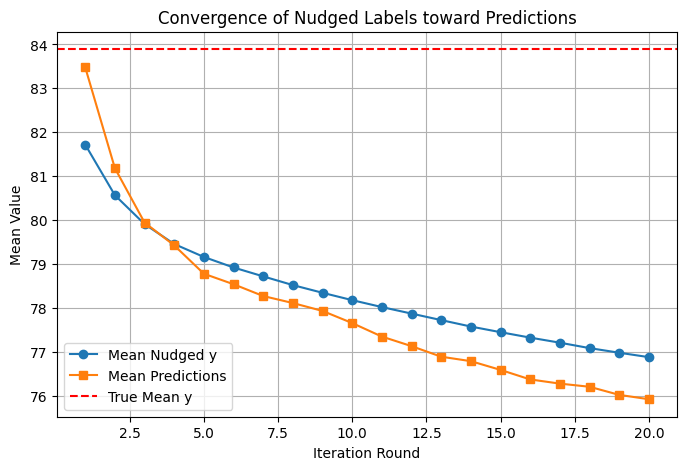

In [47]:
plt.figure(figsize=(8,5))
plt.plot(results["round"], results["mean_current_y"], marker="o", label="Mean Nudged y")
plt.plot(results["round"], results["mean_all_preds"], marker="s", label="Mean Predictions")
plt.axhline(y=results['true_mean'].iloc[0], color='r', linestyle='--', label="True Mean y")

plt.xlabel("Iteration Round")
plt.ylabel("Mean Value")
plt.title("Convergence of Nudged Labels toward Predictions")
plt.legend()
plt.grid(True)
plt.show()

In [48]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import numpy as np

def animate_moral_licensing_linear_dots(y, nudged_history, pred_history, target_val=80, save_path=None):
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # set fixed y limit
    ax.set_ylim(0, 100)
    n_samples = len(y)
    # set X axis range (students count)
    ax.set_xlim(0, n_samples)
    
    # 1. Green line: Target (horizontal line, the only line)
    ax.axhline(y=target_val, color='green', linestyle='--', linewidth=2, label=f"Target ({target_val})")

    # 2. rank index based on first prediction
    first_pred = np.asarray(pred_history[0]).ravel()
    sort_idx = np.argsort(first_pred)
    x_axis = np.arange(n_samples)
    
    # 3. Gray dots：Ground Truth 
    y_sorted = np.asarray(y)[sort_idx]
    ax.scatter(x_axis, y_sorted, color="grey", alpha=0.3, s=25, label="Ground Truth")

    # 4. Initialize dynamic points (blue dots & red dots)
    scat_blue = ax.scatter([], [], color="blue", alpha=0.6, s=30, label="Prediction")
    scat_red  = ax.scatter([], [], color="red", alpha=0.8, s=30, label="Nudged Performance")

    ax.legend(loc='upper left')
    ax.set_xlabel("Student Index (Sorted by Initial Prediction)")
    ax.set_ylabel("Score")
    
    n_frames = min(len(pred_history), len(nudged_history) - 1)

    def update(frame):
        ax.set_title(f"Moral Licensing Iteration {frame+1}")
        
        current_preds = np.asarray(pred_history[frame]).ravel()
        current_nudged = np.asarray(nudged_history[frame+1]).ravel()
        
        # sort_idx is fixed to keep the same order throughout the animation
        pred_sorted = current_preds[sort_idx]
        nudged_sorted = current_nudged[sort_idx]
        
        # update blue dot positions
        scat_blue.set_offsets(np.c_[x_axis, pred_sorted])
        
        # update red dot positions
        scat_red.set_offsets(np.c_[x_axis, nudged_sorted])
        
        return scat_blue, scat_red

    ani = animation.FuncAnimation(
        fig, update, frames=n_frames, interval=800, blit=True
    )

    if save_path:
        ani.save(save_path, writer="pillow" if save_path.endswith(".gif") else "ffmpeg")
    else:
        plt.show()

In [41]:
len(pred_history)

20

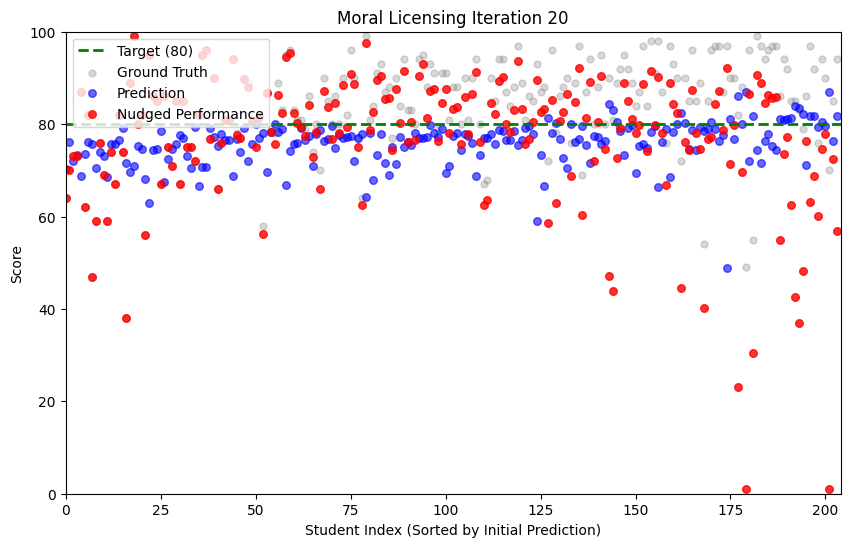

In [49]:
animate_moral_licensing_linear_dots(y, nudged_history, pred_history, target_val=80, save_path="Moral_Licensing_animation.gif")

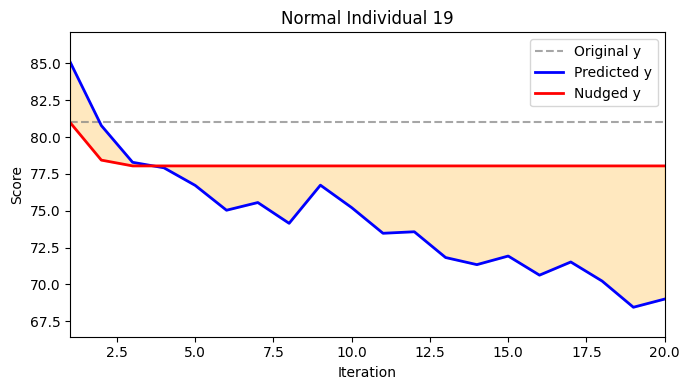

In [ ]:
import matplotlib.pyplot as plt

selected_indices = [19]    # selected individuals to observe
n_rounds = len(pred_history)
x_iter = range(1, n_rounds + 1)

# Set fixed y-axis range (min/max across all individuals)
all_preds = [pred_history[t] for t in range(n_rounds)]
all_nudged = [nudged_history[t] for t in range(n_rounds)]
y_min = min(min(p[i] for p in all_preds + all_nudged) for i in selected_indices)
y_max = max(max(p[i] for p in all_preds + all_nudged) for i in selected_indices)

fig, axes = plt.subplots(len(selected_indices), 1, figsize=(7, 4 * len(selected_indices)))

if len(selected_indices) == 1:
    axes = [axes]  # Ensure axes is iterable

for ax, idx in zip(axes, selected_indices):
    orig_score = [y[idx]] * n_rounds
    pred_scores = [pred_history[t][idx] for t in range(n_rounds)]
    nudged_scores = [nudged_history[t][idx] for t in range(n_rounds)]

    ax.plot(x_iter, orig_score, color='grey', linestyle='--', alpha=0.7, label='Original y')
    ax.plot(x_iter, pred_scores, color='blue', linewidth=2, label='Predicted y')
    ax.plot(x_iter, nudged_scores, color='red', linewidth=2, label='Nudged y')
    ax.fill_between(x_iter, pred_scores, nudged_scores, color='orange', alpha=0.25)

    ax.set_xlim(1, n_rounds)
    ax.set_ylim(y_min - 2, y_max + 2)
    ax.set_xlabel("Iteration")
    ax.set_ylabel("Score")
    ax.set_title(f"Normal Individual {idx}")
    ax.legend(loc='best')
    ax.grid(False)

plt.tight_layout()
plt.show()
